In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [142]:
data = pd.DataFrame()

data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.4, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]

In [4]:
r = 0
t = 0
S = 100
sigma = 0.2
T=1

def calculate_d1_d2(data, r, sigma):
    data['d1'] = (np.log(S / data["strikes"]) + (r + (sigma**2) / 2) * 1) / (sigma * np.sqrt(1))
    data['d2'] = data['d1'] - sigma * np.sqrt(1)
    
def calculate_call_price(data, r):
    data['black_scholes_price'] = S * norm.cdf(data['d1']) - data["strikes"] * np.exp(-r * 1) * norm.cdf(data['d2'])  
    
calculate_d1_d2(data, r, sigma)
calculate_call_price(data, r) #Estimation Black Scholes

In [165]:
import scipy.stats as ss
from decimal import Decimal
import math as m
import numpy as np
from datetime import date,timedelta

def call_bsm (S0,K,r,T,Otype,sig):
    d1 = (m.log(S0/K)) + (r+ (sig*sig)/2)*T/(sig*(m.sqrt(T)))
    d2 = d1 - sig*(m.sqrt(T))
    if (Otype == "Call"):
        price = S0*(ss.norm.cdf(np.float(d1))) \
        - K*(m.exp(-r*T))*(ss.norm.cdf(np.float(d2)))
        return (price)
    elif (Otype == "Put"):
        price  = -S0*(ss.norm.cdf(np.float(-d1)))\
        + K*(m.exp(-r*T))*(ss.norm.cdf(np.float(-d2)))
        return (price)

def vega (S0,K,r,T,sig):
    d1 = (m.log(S0/K))/(sig*(m.sqrt(T))) + ((r+ (sig*sig)/2)*T/(sig*(m.sqrt(T))))
    vega = S0*(ss.norm.pdf(np.float(d1)))*(m.sqrt(T))
    return(vega)
    
    
def imp_vol(S0, K, T, r, market,flag):
    e = 10e-15; x0 = (1);  
    def newtons_method(S0, K, T, r, market,flag,x0, e):
        delta = call_bsm (S0,K,r,T,flag,x0) - market
        while delta > e:
            x0 = (x0 - (call_bsm (S0,K,r,T,flag,x0) - market)/vega (S0,K,r,T,x0))
            delta = abs(call_bsm (S0,K,r,T,flag,x0) - market)
        return((x0))
    sig =  newtons_method(S0, K, T, r, market,flag,x0 , e)   
    return(sig)


In [166]:
data_test = data.copy()
data_test

,strikes,prices,implied_vol
0,95,10.93,0.210948
1,96,9.55,0.189023
2,97,8.28,0.170031
3,98,7.40,0.160956
4,99,6.86,0.160079
5,100,6.58,0.165124
6,101,6.52,0.175031
7,102,6.49,0.185098
8,103,6.47,0.194908
9,104,6.46,0.204530


In [167]:
iv = []

r = 0
t = 0
S = 100
sigma = 0.2
T=1
flag = 'Call'

for i,j in zip(data_test['strikes'],data_test['prices']):
    iv.append(imp_vol(S,i,T,r,j,'Call'))
data_test["implied_vol"] = iv

C:\Users\user\AppData\Local\Temp\ipykernel_9388\2895319876.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  price = S0*(ss.norm.cdf(np.float(d1))) \
C:\Users\user\AppData\Local\Temp\ipykernel_9388\2895319876.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  - K*(m.exp(-r*T))*(ss.norm.cdf(np.float(d2)))
C:\Users\user\AppData\Local\T

In [169]:
data_test

,strikes,prices,implied_vol
0,95,10.93,0.214806
1,96,9.55,0.191908
2,97,8.28,0.171904
3,98,7.40,0.161847
4,99,6.86,0.160302
5,100,6.58,0.165124
6,101,6.52,0.175224
7,102,6.49,0.185800
8,103,6.47,0.196357
9,104,6.46,0.206900


In [161]:
def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']  # Prix d'exercice
    price_market = row['prices']  # Prix du marché
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  # Prix calculé par le modèle
        vega = S * np.sqrt(T) * norm.pdf(d1)  # Vega
        price_diff = price_market - price_model  # Différence de prix                  
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        if sigma < 0:               
            sigma = 0.001     
    return sigma

# Application de la fonction au DataFrame
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)
data["implied_vol"]

0    0.210948
1    0.189023
2    0.170031
3    0.160956
4    0.160079
5    0.165124
6    0.175031
7    0.185098
8    0.194908
9    0.204530
Name: implied_vol, dtype: float64

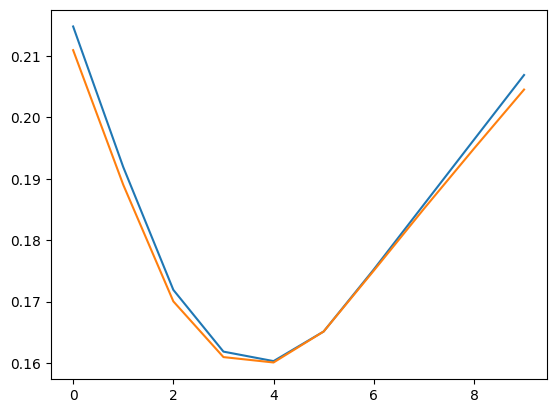

In [170]:
data_test['implied_vol'].plot()
data['implied_vol'].plot()

plt.show()

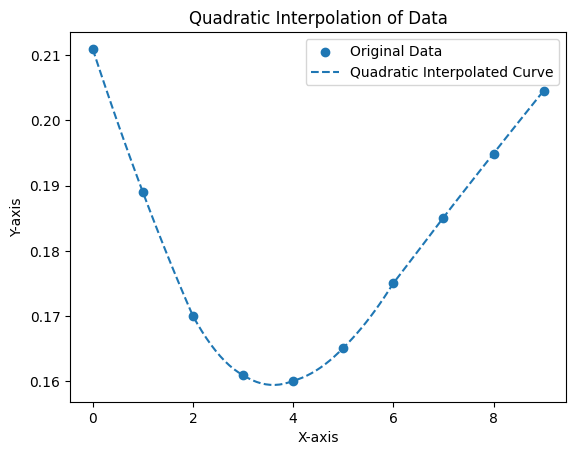

In [7]:
#quadratic interp for better smoothing of the curve

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []

    for x in x_interpolated:
        # Find the segment in which x falls
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        # Quadratic interpolation formula
        # Solving for coefficients a, b, and c of the quadratic equation y = ax^2 + bx + c
        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)

        # Calculate the interpolated y value
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

# Example data
# Replace 'data.index' and 'data["implied_vol"]' with your actual data
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

# Plotting
plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, y_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Quadratic Interpolation of Data')
plt.show()

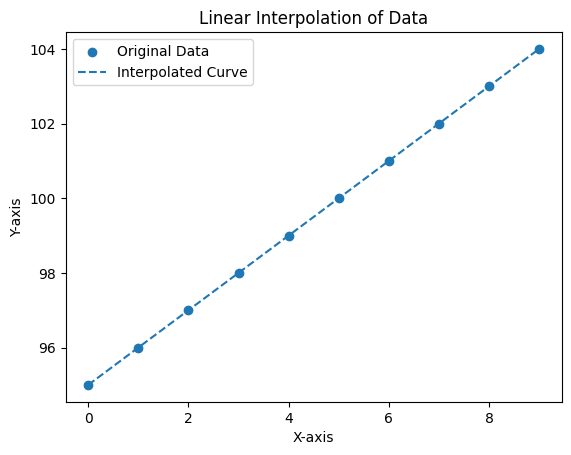

In [8]:
#interpolation of strikes

x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Linear Interpolation of Data')
plt.show()

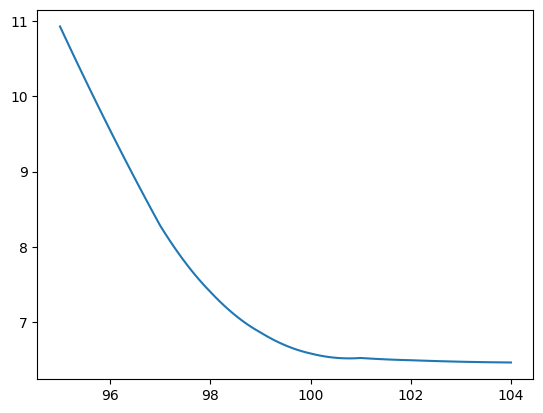

In [9]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

prices=[]

for i,j in zip(strike_interpolated,y_interpolated):
    prices.append(black_scholes_call_price(S,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(df["Strike"],df["Price"])


In [13]:
df['Strike']


0      95.000000
1      95.090909
2      95.181818
3      95.272727
4      95.363636
         ...    
95    103.636364
96    103.727273
97    103.818182
98    103.909091
99    104.000000
Name: Strike, Length: 100, dtype: float64

# II – Interpolation et volatilité locale 

3/ Déterminez la nappe de volatilité correspondant à ces 40 options. Proposer un prix, le plus juste 
possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue).

In [133]:
data_12_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                'prices': [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]}

df_12_months = pd.DataFrame(data_12_months)

data_9_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices':[11.79 ,8.95 ,8.07 ,7.03 ,6.18 ,6.04 ,5.76 ,5.50 ,5.50 ,5.39]}

df_9_months = pd.DataFrame(data_9_months)

data_6_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                    'prices': [10.71 ,8.28 ,6.91 ,6.36 ,5.29 ,5.07 ,4.76 ,4.47 ,4.35 ,4.14]}
df_6_months = pd.DataFrame(data_6_months)

data_3_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices': [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]}

df_3_months = pd.DataFrame(data_3_months)


# On utilise l'algorithme de Newton Raphson pour trouver les volatilités implicites

df_12_months["implied_vol"] = df_12_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)
df_9_months["implied_vol"] = df_9_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)
df_6_months["implied_vol"] = df_6_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)
df_3_months["implied_vol"] = df_3_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)



On utilise la fonction d'interpolation quadratique, pour lisser la courbe

In [172]:
def interpolation(data):
    prices = []
    #interpolation of vol
    x_original = np.array(data.index)
    y_original = np.array(data["implied_vol"])

    nb_pts = 100
    x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
    y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

    #interpolation of strikes
    x_original=data.index
    y_original=data["strikes"]
    x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
    strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

    #Calcul des prix avec la formule de black scholes en fonction des paramêtres interpolés
    for i,j in zip(strike_interpolated,y_interpolated):
        prices.append(black_scholes_call_price(S,i,T,r,j))
    df=pd.DataFrame([prices,strike_interpolated,y_interpolated],index=["prices","strikes",'implied_vol']).T
    return df

In [136]:
df_12_months = interpolation(df_12_months)
df_9_months = interpolation(df_9_months)
df_6_months = interpolation(df_6_months)
df_3_months = interpolation(df_3_months)

In [137]:
df_12_months['maturité'] =  [1]*100
df_9_months['maturité'] = [0.75]*100
df_6_months['maturité'] = [0.5]*100
df_3_months['maturité'] = [0.25]*100

# print("Options de maturité 9 mois:")
# print(df_9_months)

# print("\nOptions de maturité 6 mois:")
# print(df_6_months)

# print("\nOptions de maturité 3 mois:")
# print(df_3_months)

In [138]:
df_concatenated = pd.concat([df_12_months,df_9_months, df_6_months, df_3_months])

print(df_concatenated)

       prices     strikes  implied_vol  maturité
0   12.400000   95.000000     0.249966      1.00
1   12.083580   95.090909     0.242875      1.00
2   11.779283   95.181818     0.236113      1.00
3   11.487132   95.272727     0.229681      1.00
4   11.207151   95.363636     0.223577      1.00
..        ...         ...          ...       ...
95   2.588067  103.636364     0.102360      0.25
96   2.572396  103.727273     0.102767      0.25
97   2.557499  103.818182     0.103190      0.25
98   2.543370  103.909091     0.103626      0.25
99   2.530000  104.000000     0.104078      0.25

[400 rows x 4 columns]


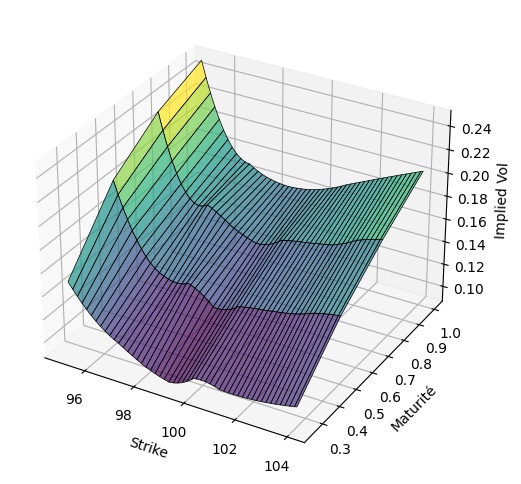

In [139]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface
ax.plot_surface(df_concatenated['strikes'].values.reshape(4, -1),
                df_concatenated['maturité'].values.reshape(4, -1),
                df_concatenated['implied_vol'].values.reshape(4, -1),
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('Implied Vol')

plt.show()

In [132]:
df_concatenated


,prices,strikes,implied_vol,maturité
0,10.930000,95.000000,0.210948,1.00
1,10.800166,95.090909,0.208834,1.00
2,10.671194,95.181818,0.206743,1.00
3,10.543090,95.272727,0.204678,1.00
4,10.415857,95.363636,0.202636,1.00
...,...,...,...,...
95,2.588067,103.636364,0.102360,0.25
96,2.572396,103.727273,0.102767,0.25
97,2.557499,103.818182,0.103190,0.25
98,2.543370,103.909091,0.103626,0.25
